# Regridding
This notebook is an explanation for how the regrid in regrid_data.py is conducted, and the sanity checks that are available. 

Our goal is to go from the "base" noaa csl data, which is projected in Lambert Conformal Coordinates, to a lat/long (WGS) coordinate projection. The base data also has some inconsistencies, so we also standardize thinks like dimensions and attributes in the datasets. Part of the regridding process is a bit of unit conversion (to go from "absolute" units per gridcell to "flux" per m2). 

Lots of useful information was found here:       
https://medium.com/pangeo/changing-the-way-you-look-at-earth-data-with-xesmf-ee55d0b380e5          
https://fabienmaussion.info/2018/01/06/wrf-projection/     


In [1]:
#Import packages
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import sys
import cartopy.io.img_tiles as cimgt
import os
import numpy as np

sys.path.append('..')
import noaa_csl_funcs as ncf
from regrid_data import RegridInputs

In [5]:
#Define the day of data we want to regrid, and load it 
regrid_index = 2
species = ['CO2','CO','HC01','HC02','HC14','NH3','NOX','SO2']
base_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base' #where the data downloaded using data_download.py lives
bau_or_covid = 'COVID'
full_sector = 'area_onroad_gasoline'
year = 2019
month = 1
day_type = 'weekdy'
BCH = ncf.Base_CSL_Handler(base_path,bau_or_covid,species = species)
base_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})
base_ds
#base_ds = base_ds[species]

<xarray.Dataset>
Dimensions:   (utc_hour: 24, south_north: 1008, west_east: 1332)
Coordinates:
    XLAT      (south_north, west_east) float32 18.19 18.2 18.21 ... 52.42 52.41
    XLONG     (south_north, west_east) float32 -121.8 -121.7 ... -58.63 -58.58
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: south_north, west_east
Data variables:
    CO2       (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    CO        (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC01      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC02      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC14      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    NH3       (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    NOX       (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    SO2       (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
Attributes: (12/35)
    WEST-EAST_GRID_DIMENSION:        1333
    SOUTH-NORTH_GRID_DIMENSION:      1009
    DX:                              4000.0
    DY:                              4000.0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1332
    ...                              ...
    grid_type:                       area
    sector_id:                       onroad_gasoline
    year:                            2019
    month:                           1
    day_type:                        weekdy
    nc_fpath:                        /uufs/chpc.utah.edu/common/home/lin-grou...

In [3]:
#Need to convert from "absolute" units per gridcell to "flux" units in per m^2
unit_converter = ncf.CSL_Unit_Converter() #setup the unit converter
ds_flx = unit_converter.absolute_to_flux(base_ds) #convert absolute to flux (divide by the area of the grid cell in m^2 per Colin Harkins = 4000m*4000m)
print('units = ',ds_flx['CO2'].attrs['units'])

units =  metric_Ton hr^-1 meters^-2


In [4]:
#Define inputs to the regridder
#weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights' #define the weights path
#weights_file = 'lcc_to_latlon_onroad_gasoline_2019_1_weekdy.nc' #this can be set to 'create', and it will create the weights based on the input dataset

inputs = RegridInputs(weights_file = 'create')#Define the inputs. these are the defaults, with the addition of the weights file. 
inputs.grid_out = {
    'lat': np.arange(18.95, 58.05, 0.025),  # Center Point Spacing Lat
    'lon': np.arange(-138.05, -58.95, 0.025),  # Center Point Spacing Lon
    'lat_b': np.arange(18.95-0.0125, 58.05+0.0125, 0.025),  # Boundary Spacing Lat
    'lon_b': np.arange(-138.05-0.0125, -58.95+0.0125, 0.025),  # Boundary Spacing Lon
}

cr = ncf.CSL_Regridder(inputs) #create the regridder class
regridded_ds = cr.regrid_ds(ds_flx) #regrid the dataset


Creating regridder


In [7]:
# You can save the regridder's weights to a file so you don't have to create it every time
#cr.save_regrid_weights(cr.regridder) #this will save it to a default name like the one above. can also input a specific name

### Sanity Checking

To check our sanity, we want to compare the data before we regridded it to after we regridded it. To do this, we need to convert to a common unit, as the before data was in LCC per gridcell, and the regridded data is in lat/lon in flux. 

In [5]:
#Load the original dataset
og_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})
#og_ds

In [6]:
#Save a subset o fthe regridded data as a netcdf 
sub_regridded_ds = regridded_ds['CO2'][1,:,:]
sub_regridded_ds.to_netcdf(f'../regridding/grid_area/grid_out{regrid_index}.nc')

Open a terminal in this subdir and run. This will create an nc file with grid cell area as a data variable
> cdo gridarea ./regridding/grid_area/grid_out.nc ./regridding/grid_area/grid_out_area.nc

In [7]:
#Now we should have a file with the grid area
grid_area = xr.open_dataset(f'../regridding/grid_area/grid_out_area{regrid_index}.nc')
#grid_area

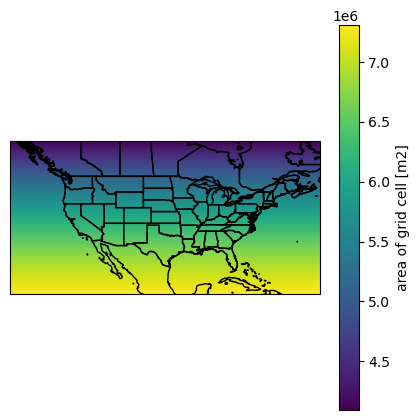

In [8]:
#Plot the grid cell area on a map -- should be less to the north and more to the south due to earth's shape
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection = proj)
grid_area['cell_area'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

Now we can do the actual sanity check by looking at the sum of all values in the grid for a specific species both before and after regridding and compare their difference. 

In [9]:
regridded_ds_cellarea = xr.open_dataset(f'../regridding/grid_area/grid_out_area{regrid_index}.nc')
perc_diff = ncf.sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,'CO2')

CO2 sum diff = 0.265%


### Map
Perhaps the best sanity check is to look on a map and see if it makes sense

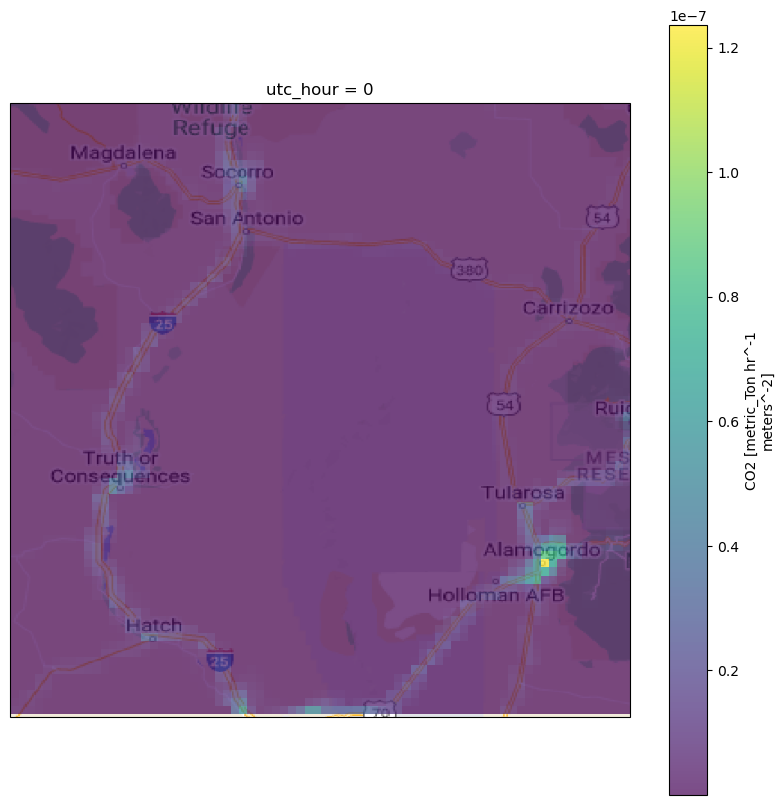

In [10]:
utc_hour = 0
species = 'CO2'

# map_extent={'lon_low':-115.4,
#             'lon_high':-109.6,
#             'lat_low':38.5,
#             'lat_high':45.0}
map_extent={'lon_low':-107.59,
            'lon_high':-105.69,
            'lat_low':32.430,
            'lat_high':34.31} 


cropped_ds = regridded_ds.sel(lat=slice(map_extent['lat_low'],map_extent['lat_high']), lon=slice(map_extent['lon_low'],map_extent['lon_high']))

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)

request = cimgt.GoogleTiles(style='street')
scale = 8.0 # prob have to adjust this
ax.add_image(request,int(scale))

cropped_ds.sel({'utc_hour':utc_hour})['CO2'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis',alpha = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

## Other Inventories

In [13]:
#Functions for loading and dealing with other inventories
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    if spec in ['CH4','CO2']:
        nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_{emi_or_flx}_nc'
        nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    elif spec == 'CO':
        nc_folder_name = f'EDGARv6.1_{spec}_{year}_TOTALS.0.1x0.1'
        nc_file_name = (nc_folder_name) + '.nc'

    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    try:    
        ds = xr.open_dataset(nc_fullpath)
    except FileNotFoundError as f:
        print(f)
        raise FileNotFoundError(f'There doesnt seem to be data for this configuration:{spec},{emi_or_flx},{year}')
    if spec == 'CO':
        ds = coord_change_360_180(ds)
        ds = ds.rename({'emi_co':'fluxes'})
        ds['fluxes'].attrs['substance'] = 'CO'

    gca_fname = nc_file_name.split('.nc')[0] + '_gca' + '.nc'
    try:
        gca_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,gca_fname)
        gca_ds = xr.open_dataset(gca_fullpath)
        if spec == 'CO':
            gca_ds = coord_change_360_180(gca_ds)
        ds = add_gca_to_ds(ds,gca_ds)
    except FileNotFoundError:
        print(f'No grid cell area file {gca_fullpath} found. Create with cdo to use. Returning ds without gca')
        return ds

    return ds

def coord_change_360_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

def add_gca_to_ds(orig_ds,gca_ds):
    orig_ds['grid_cell_area'] = gca_ds['cell_area']
    return orig_ds

def load_epa_nc(path,year):
    fname = f'Express_Extension_Gridded_GHGI_Methane_v2_{year}.nc'
    ds = xr.open_dataset(os.path.join(path,fname))
    name_map = {k: k.replace('emi','flx') for k in ds} #in the nc file, the data variables are names "emi..." which is confusing as they are fluxes. so rename to flx...
    ds = ds.rename(name_map)
    return ds    

In [22]:
#Define Parameters
map_extent={'lon_min':-112.25,
            'lon_max':-111.55,
            'lat_min':40.3,
            'lat_max':41.1} 
dataset_extent = {'lon_min':-112.16,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 

utc_hour = 0
species = 'HC01'

In [23]:
# Load the Edgar and Maasakers inventories 

# Load Edgar inventory
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'
spec = 'CH4'
emi_or_flx = 'flx'
edgar_full_ds = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
edgar_sub_ds = ncf.slice_extent(edgar_full_ds,dataset_extent)
if emi_or_flx == 'flx':
    edgar_sub_ds['emissions'] = (edgar_sub_ds['grid_cell_area'] * edgar_sub_ds['fluxes']) * 86400 * 365 * 1E-3 # [m2] * [kg/m2/s] * [86400s/d] *[365d/y] *[1E-3tonne/kg] = [tonne/yr]
    edgar_sub_ds['emissions'].attrs = {'substance':spec,'units':'Tonne'}


#Load the Maasakkers data
epa_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/Maasakkers'
epa_full_ds = load_epa_nc(epa_path,year)
epa_subds = ncf.slice_extent(epa_full_ds,dataset_extent).sum(dim="time",keep_attrs = True)
#Sum variables
data_variables = list(epa_subds.keys()) #all of the vars in the nc file
emi_variables = [var for var in data_variables if var != 'grid_cell_area'] #drop the grid cell area from the variables list so we can sum
og_units = epa_subds[emi_variables[0]].attrs['units']
for emi_var in emi_variables: #check to make sure the units are the same on all of the emissions variables
    if epa_subds[emi_var].attrs['units'] != og_units:
        raise ValueError(f'The units are different in {emi_var}, so you shouldnt sum')
epa_subds['flx_ch4_sum'] = epa_subds[emi_variables].to_array().sum('variable') #sum along the emissions variables
epa_subds['flx_ch4_sum'].attrs = {'units':og_units} #add the units
#convert flux units to emissions units
# emissions[tonne/yr] = grid_cell_area[cm2] * flx_ch4[molec/cm2/s] * (1/6.022E23)[mol/molec] * 16.04[gch4/mol] * 86400[s/d] * 365[d/y] * 1E-6[tonne/g]
epa_subds['emissions'] = (epa_subds['grid_cell_area']*epa_subds['flx_ch4_sum'])*(1/6.022E23)*16.04*86400*365*1E-6  #multiply the sums by the grid cell area
epa_subds['emissions'].attrs['units'] = 'Tonnes'

In [24]:
cropped_ds = ncf.slice_extent(regridded_ds,dataset_extent)

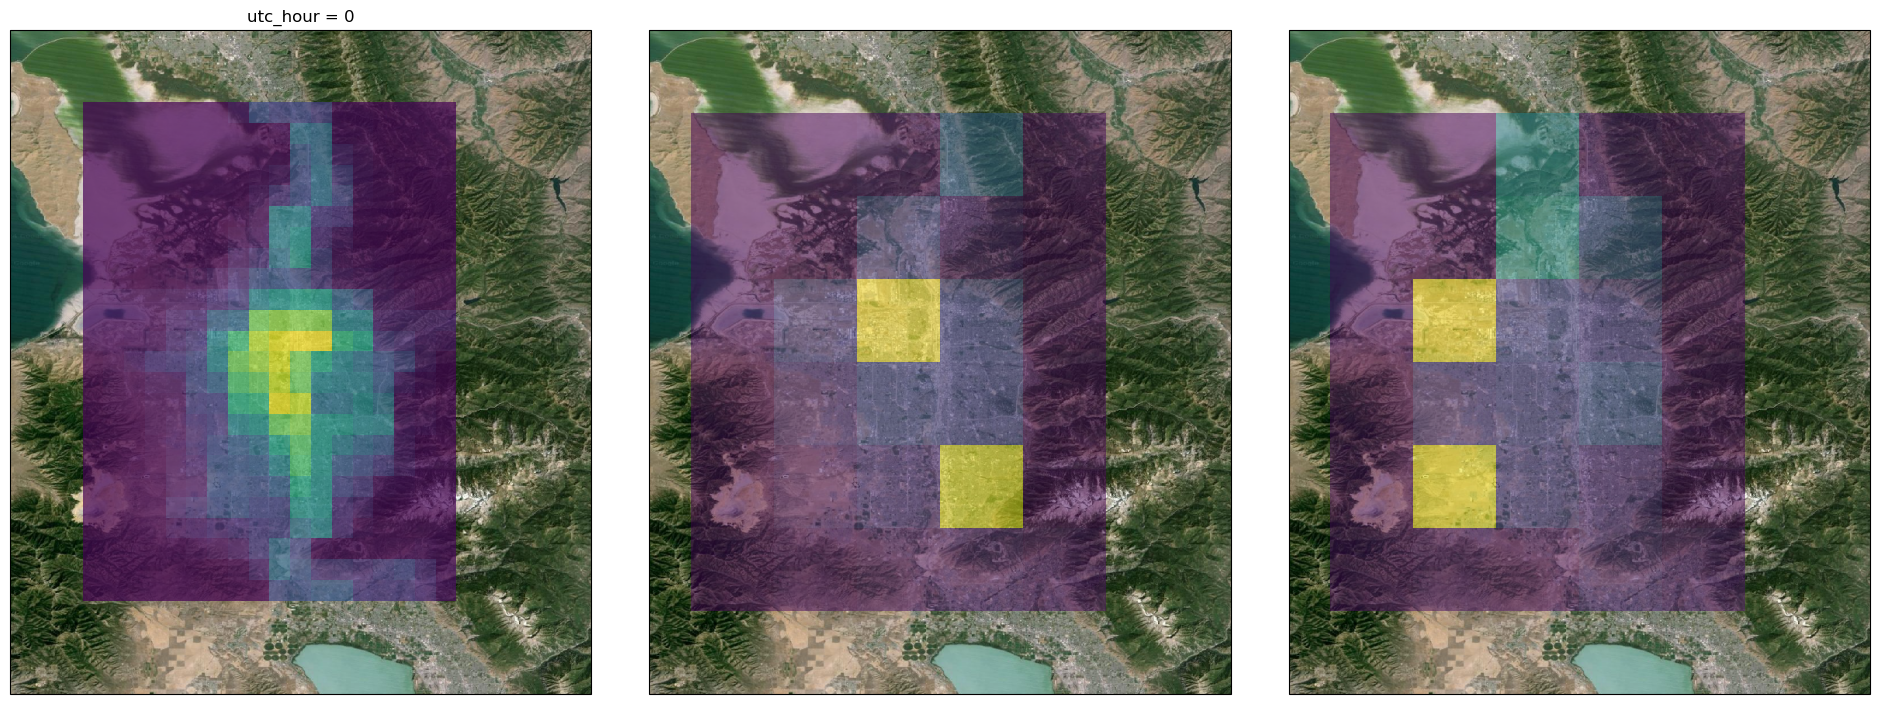

In [25]:
# Plot comparisons

if species == 'HC01':
    spec_lab = 'CH4'
else:
    spec_lab = species
labsize = 16
proj = ccrs.PlateCarree()

fig, axs = plt.subplots(1,3, figsize=(24, 10), subplot_kw={"projection": proj},width_ratios=(1,1,1))
request = cimgt.GoogleTiles(style='satellite')
scale = 11.0 # prob have to adjust this
for i in range(0,3):
    axs[i].set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)
    axs[i].add_image(request,int(scale))

csl_plot = cropped_ds.sel({'utc_hour':utc_hour})[species].plot.pcolormesh('lon','lat',ax = axs[0],cmap = 'viridis',alpha = 0.7,add_colorbar=False)
edgar_plot = edgar_sub_ds['emissions'].plot.pcolormesh('lon','lat',ax=axs[1],alpha = 0.5,add_colorbar=False,vmin = 0, vmax = 5000)
epa_plot = epa_subds['emissions'].plot.pcolormesh('lon','lat',ax=axs[2],alpha = 0.5,add_colorbar=False,vmin = 0, vmax = 5000)


plt.subplots_adjust(wspace=0.1)
plt.show()